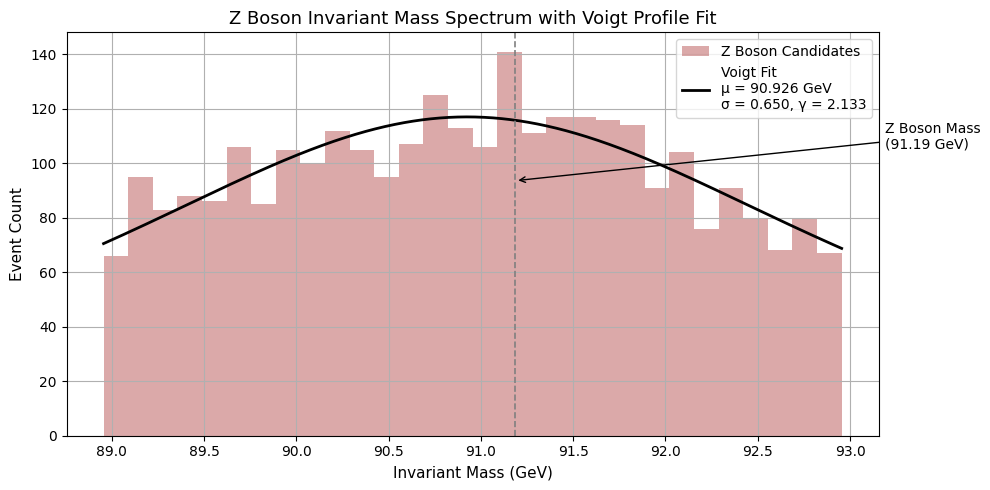

✅ Total Z events identified: 4015
✅ Events used in Voigt fit (±2 GeV around mean): 2950
✅ Voigt Fit Parameters:
  - μ = 90.926 GeV
  - σ = 0.650
  - γ = 2.133


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import wofz

# --- 1. Load and Classify Data ---
data = pd.read_csv('/Users/xDAyN/Desktop/cs project/School Project/Dimuon_DoubleMu.csv')

# Z boson mass window
mZ_nominal = 91.1876
total_uncertainty = 0.04
mass_lower = mZ_nominal * (1 - total_uncertainty)
mass_upper = mZ_nominal * (1 + total_uncertainty)

def classify_mass(mass):
    return 5 if mass_lower <= mass <= mass_upper else 6

data['label'] = data['M'].apply(classify_mass)

masses_z = data[data['label'] == 5]['M']
total_z_events = len(masses_z)

# --- 2. Voigt Profile ---
def voigt(x, amp, center, sigma, gamma):
    z = ((x - center) + 1j * gamma) / (sigma * np.sqrt(2))
    return amp * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))

# --- 3. Fit Setup ---
fit_window_width = 2.0
mean = masses_z.mean()
fit_mask = (masses_z > mean - fit_window_width) & (masses_z < mean + fit_window_width)
masses_fit = masses_z[fit_mask]
events_in_window = fit_mask.sum()

# Histogram
bins = 30
counts, bin_edges = np.histogram(masses_fit, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Fit
popt, _ = curve_fit(
    voigt,
    bin_centers,
    counts,
    p0=[100, 91.2, 2.5, 2.5],
    bounds=([0, 88, 0.1, 0.1], [np.inf, 94, 10, 10]),
    maxfev=10000
)

x_fit = np.linspace(bin_edges[0], bin_edges[-1], 1000)
y_fit = voigt(x_fit, *popt)

# --- 4. Plot: Histogram + Voigt Fit ---
plt.figure(figsize=(10, 5))
plt.hist(masses_fit, bins=bins, alpha=0.4, color='brown', label='Z Boson Candidates')
plt.plot(x_fit, y_fit, 'k-', linewidth=2,
         label=f'Voigt Fit\nμ = {popt[1]:.3f} GeV\nσ = {popt[2]:.3f}, γ = {popt[3]:.3f}')

plt.title('Z Boson Invariant Mass Spectrum with Voigt Profile Fit', fontsize=13)
plt.xlabel('Invariant Mass (GeV)', fontsize=11)
plt.ylabel('Event Count', fontsize=11)
plt.axvline(mZ_nominal, color='gray', linestyle='--', linewidth=1.2)
plt.annotate('Z Boson Mass\n(91.19 GeV)', xy=(mZ_nominal, max(y_fit)*0.8),
             xytext=(mZ_nominal+2, max(y_fit)*0.9),
             arrowprops=dict(arrowstyle='->', color='black'), fontsize=10)

plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 5. Summary ---
print(f"✅ Total Z events identified: {total_z_events}")
print(f"✅ Events used in Voigt fit (±2 GeV around mean): {events_in_window}")
print(f"✅ Voigt Fit Parameters:\n  - μ = {popt[1]:.3f} GeV\n  - σ = {popt[2]:.3f}\n  - γ = {popt[3]:.3f}")
